In [10]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import pandas as pd
import seaborn as sns
from scipy.fft import fft, fftfreq

# Generating Data

In [11]:
def generate_data(random_state = 42): 
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True,
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

# Single-Taper (no Welch)

In [12]:
from scipy.signal import periodogram

def single_taper_psd(signal, window_length_sec, taper_shape, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:] # obtain last chunk
    freqs, psd = periodogram(x, fs=fs, window=taper_shape, scaling='density', return_onesided=True)
    # drop nyquist bin
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]
    return freqs, psd

# Multitaper

In [13]:
from spectral_connectivity import Multitaper, Connectivity 

def multitaper_psd(signal, window_length_sec, TW = 1, K = None, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:] # obtain last chunk
    
    mt = Multitaper(time_series = x, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    
    connectivity = Connectivity.from_multitaper(mt)
    freqs = connectivity.frequencies # dim:(250,)
    psd = connectivity.power().reshape(-1) # flatten (250, ) --> (1, 250, 1)
    return freqs, psd

# Plotting

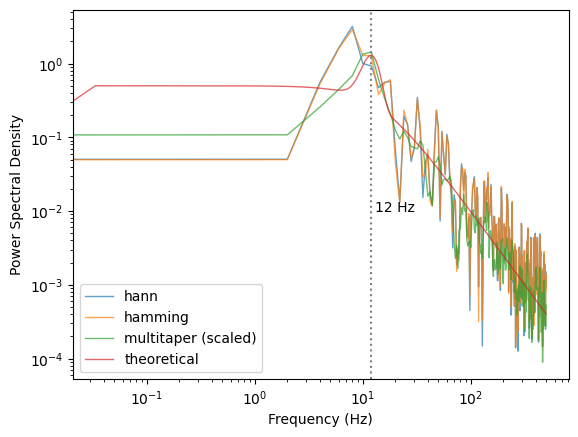

In [14]:
import matplotlib.pyplot as plt

window_length = 0.5 # change window length

freq_hann, psd_hann = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hann')
freq_hamming, psd_hamming = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hamming')
freq_mt, psd_mt = multitaper_psd(data_td, window_length_sec=window_length, TW=2)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')
plt.plot(data_fd.frequencies, data_fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias Function

In [15]:
def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    biases = abs(empiricalPSD - theoreticalPSD) # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N
    return meanBias

# Violin Plots

In [16]:
def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    from scipy.interpolate import interp1d
    interpolator = interp1d(freq_theoretical_fd, psd_theoretical_fd, bounds_error=False, fill_value=np.nan)
    return interpolator(freq_empirical)

In [17]:
window_length = 0.5
tw = 1
 
freq_theo, psd_theo = data_fd.frequencies, data_fd.combined_spectrum

df = pd.DataFrame(columns=['hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])
for random_state in range(100): # generate data multiple times

    data = generate_data(random_state=random_state)
    data_td = data.time_domain.combined_signal
    data_fd = data.frequency_domain
    
    freq_hann, psd_hann = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hann')
    freq_hamming, psd_hamming = single_taper_psd(data_td, window_length_sec=window_length, taper_shape='hamming')
    freq_mt, psd_mt = multitaper_psd(data_td, window_length_sec=window_length, TW = tw)

    psd_theo = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_hamming)

    df.loc[len(df)] = [calc_mean_bias(psd_hamming, psd_theo),
                       calc_mean_bias(psd_hann, psd_theo), 
                       calc_mean_bias(psd_mt, psd_theo)]

<Axes: title={'center': 'Bias by Taper Method, Window Length = 0.5s'}>

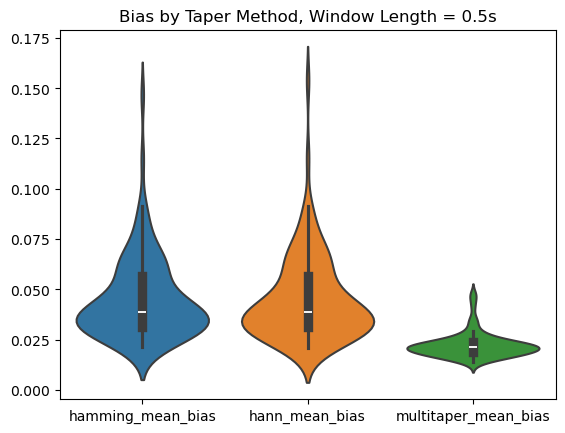

In [18]:
plt.title(f"Bias by Taper Method, Window Length = {window_length}s")
sns.violinplot(data=df, linewidth=1.5)